#**PROJET "*IDENTIFICATION D'UNE LANGUE*" RÉALISÉ PAR M. BOROVIKOVA, C. NINEB ET F. AUFFRET**

#Installation des modules pré-requis
Après l'execution de cette cellule il est impératif de relancer le runtime, si vous utilisez Google Colab.

In [2]:
%%capture
!pip install praat-parselmouth
!pip install pandas_ml
!pip install scikit-learn==0.21
!pip install pandas==0.24.2
!pip install ipywidgets

#Import des modules nécessaires et désactivation des avertissements

In [ ]:
import parselmouth
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import interpolate

from pandas_ml import ConfusionMatrix
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import glob
import cv2
from ipywidgets import widgets

#Prétraitement des fichiers audio
Pour utiliser cette partie-là il faut d'abord télécharger des corpus utilisés et de les mettre dans la répértoire "audio" chacune dans sa propre répértoire.

De plus, vous devriez avoir une bonne volume de RAM. Nous avons lancé cette cellule sur nos propres machines, parce que quand on utilise Google Colab, cela crashe faute de RAM après ≈25 fichiers pour hindi et après ≈40 fichiers pour les autres langues.

###*Attention!*
Les fichiers audio ne doivent contenir des points dans ses noms (à part ceux qui marquent l'extension).

*Par exemple, "my_audio.wav" est un nom valide, alors que "my.audio.mp3" ne l'est pas.*


In [ ]:
# remplacer des zéros de numpy array pour prévenir "divide by Zero Warning" en utilisant une fonction log
def replaceZeroes(data):
  data[data == 0] = np.min(data[np.nonzero(data)])
  return data


## transformation des audios en spectrogrammes
def audio2spectro(audio, spectrodir="imagesSpectros", max_freq=8000, inches_size=(0.25, 0.25), dpi=200):
  snd=parselmouth.Sound(audio)
  spectrogram = snd.to_spectrogram(maximum_frequency=max_freq)
  X, Y = spectrogram.x_grid(), spectrogram.y_grid()
  Xbins, Ybins = spectrogram.x_bins(), spectrogram.y_bins()
  Ymid = np.column_stack((Ybins[:,0],np.diff(Ybins,axis=1)/2)).sum(axis=1)
  sg_db = 10 * np.where(spectrogram.values > 0.0000000001, np.log10(replaceZeroes(spectrogram.values)), -10)
  fig = plt.figure(frameon=False)
  fig.set_size_inches(inches_size[0], inches_size[1])
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)


  sg_bd_interp = interpolate.RectBivariateSpline(np.column_stack((Xbins[:,0],np.diff(Xbins,axis=1)/2)).sum(axis=1), Ymid, sg_db.T)(np.linspace(X[0], X[-1], 10*len(X)), np.linspace(Y[0], Y[-1], 10*len(Y))).T

  # add min value in image on the right of the image if zero_padding_width_ratio is over 0 and below 1
  zero_padding_width_ratio=(2-snd.get_total_duration())/2
  if 0 < zero_padding_width_ratio < 1:
    value_for_zero_padding=np.min(sg_bd_interp)
    zero_padded_sg_bd_interp = np.concatenate((sg_bd_interp,np.ones((sg_bd_interp.shape[0], int(np.round(sg_bd_interp.shape[1] * zero_padding_width_ratio / (1 - zero_padding_width_ratio)))))*value_for_zero_padding), axis = 1)
  else:
    zero_padded_sg_bd_interp = sg_bd_interp

  ax.imshow(zero_padded_sg_bd_interp, aspect="auto", cmap="gray_r", vmin=sg_db.max() - 70, vmax=None)
  fig.savefig(spectrodir+"/"+audio[audio.rindex("/")+1:audio.index(".")]+"png", dpi = dpi)
  plt.close(fig)  

#Préparation des données pour la réseau de neurones

In [ ]:
"""
construction du dataset pour l'entraînement,
l'argument path attends un chemin vers des spectrogrammes,
l'argument test attends un pourcentage des exemples utilisés pour le test
"""
def get_data(path = "imagesSpectros", test=10):
  x_1, y_1, x_2, y_2 = [], [], [], []
  border = 6*test
  i = 0
  for lang in glob.glob(path+'/*'):
    print(lang)
    c = 0
    for img_path in glob.glob(lang+"/*"):
      transform_data(img_path)
      c += 1
      if c <= border:
        x_2.append(img)
        y_2.append(i)
      else:
        x_1.append(img)
        y_1.append(i)
    i += 1
  x_train, y_train = transform_data(x_1, y_1)
  x_test, y_test = transform_data(x_2, y_2)
  del x_1, y_1, x_2, y_2
  return x_train, y_train, x_test, y_test

In [ ]:
#transformation d'une seule spectrogramme en array avec la forme (50, 50)
def transform_img(x):
  img = cv2.imread(x, 0).astype(np.uint8)
  img = cv2.resize(img, (50, 50))
  return img

In [ ]:
#transformation de toutes les données en numpy array convenable pour l'apprentissage du réseau ci-dessous
def transform_data(x, y):
  return np.asarray(x).reshape(-1, 50, 50, 1).astype("float32")/255, to_categorical(np.array(y).reshape(-1, 1))

#Construction de la réseau convolutive

In [ ]:
def train(x_train, y_train, x_test, y_test, path_to_save =  "models", num_classes = 4, epochs = 10, batch_size=4):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 1)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))


  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(),
                metrics=['categorical_accuracy', ])


  history = model.fit(x_train, y_train,
            validation_data=(x_test, y_test),
            epochs=epochs,
            shuffle=True,
            batch_size=batch_size,
            verbose=1,
            callbacks=[EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=3), ModelCheckpoint('models/best_loss.h5', monitor='val_loss', mode='min', save_best_only=True), ModelCheckpoint('models/best_acc.h5', monitor='val_categorical_accuracy', mode='max', save_best_only=True)])
  model.save(path_to_save)
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  return history

#L'execution de toutes les fonctions

In [ ]:
for targetdir in ("fr", "ar", "ru", "hi"):
    for path in os.listdir(targetdir):
      audio2spectro("audio/"+targetdir+"/"+path, spectrodir="imagesSpectros/"+targetdir)
x_train, y_train, x_test, y_test = get_data()
m = train(x_train, y_train, x_test, y_test)

Epoch 1/60
540/540 [==============================] - 45s 82ms/step - loss: 1.3941 - categorical_accuracy: 0.3148 - val_loss: 1.2008 - val_categorical_accuracy: 0.4708
Epoch 2/60
540/540 [==============================] - 44s 82ms/step - loss: 0.9542 - categorical_accuracy: 0.5952 - val_loss: 1.2421 - val_categorical_accuracy: 0.4708
Epoch 3/60
540/540 [==============================] - 44s 82ms/step - loss: 0.8469 - categorical_accuracy: 0.6280 - val_loss: 1.3522 - val_categorical_accuracy: 0.4625
Epoch 4/60
540/540 [==============================] - 44s 81ms/step - loss: 0.7396 - categorical_accuracy: 0.6818 - val_loss: 1.2768 - val_categorical_accuracy: 0.5292
Epoch 5/60
540/540 [==============================] - 44s 82ms/step - loss: 0.6841 - categorical_accuracy: 0.7223 - val_loss: 1.3403 - val_categorical_accuracy: 0.4917
Epoch 6/60
540/540 [==============================] - 45s 84ms/step - loss: 0.6085 - categorical_accuracy: 0.7386 - val_loss: 1.2549 - val_categorical_accuracy:

#Évaluation des résultats

In [ ]:
#chargement des modèles
model_last = keras.models.load_model('models/saved_model.pb')
model_acc = keras.models.load_model('models/best_acc.h5')
model_loss = keras.models.load_model('models/best_loss.h5')

In [ ]:
#La qualité du dernier modèle
score = model_last.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#La qualité du modèle avec la plus haute accuracy
score = model_acc.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#La qualité du modèle avec le loss le plus bas
score = model_loss.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.0650906562805176
Test accuracy: 0.574999988079071
Test loss: 2.6199047565460205
Test accuracy: 0.6333333253860474
Test loss: 1.200844645500183
Test accuracy: 0.47083333134651184


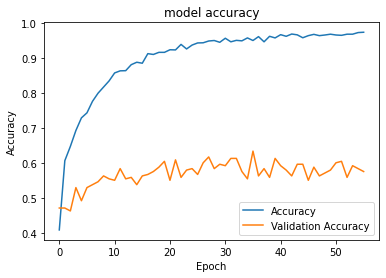

In [ ]:
#évaluation de l'accuracy
plt.plot(m.history['categorical_accuracy'])
plt.plot(m.history['val_categorical_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

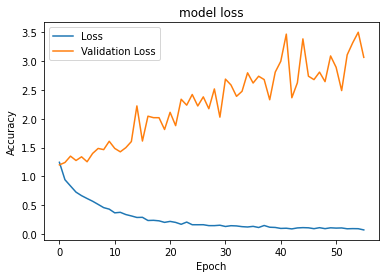

In [ ]:
#évaluation du loss
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title("model loss")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Loss", "Validation Loss"])
plt.show()

(-0.5, 3.5, 3.5, -0.5)

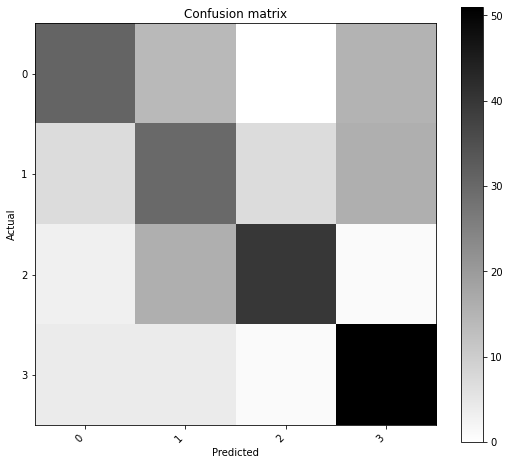

In [ ]:
#0 - russe, 1 - arabe, 2 - hindi, 3 - français
predictions = model_acc.predict(np.array(x_test))
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

#Conclusion
Le meilleur modèle prédit des bonnes labels en 60% des cas. Des expériences nous montrent que l'apprentissage se términe après 10-15 époques. Selon la matrix de confusion, on pourrait dire que la langue française se reconnait par un réseau mieux que les autres langues. Cela peut être expliqué par la présence des sons nasals. 

##P.S. Testez vous-mêmes

###*Attention!*

Si vous téléversez des fichiers avec des paramétres différents (fréquence distincte de 8000, extension distinct de mp3, etc.), bien sûr que la qualité des prédictions baisse.

In [ ]:
#téléversez un/des fichier(s) mp3 ou wav
audio_files = widgets.FileUpload(accept='.mp3,.wav', multiple=True)
audio_files

FileUpload(value={}, accept='.mp3,.wav', description='Upload', multiple=True)

In [ ]:
#donnez au Python un accès à ces fichiers
if "user_data" not in os.listdir(): os.mkdir("user_data")
if "audio" not in os.listdir("user_data"): os.mkdir("user_data/audio")
for audio_file in audio_files.value.values():
  with open("user_data/audio/"+audio_file["metadata"]["name"], "wb") as out: out.write(audio_file["content"])

In [ ]:
#regardez le résultat
os.chdir("user_data")
if "spectros" not in os.listdir(): os.mkdir("spectros")
for audio in list(filter(lambda x: x[-4:] in [".mp3", ".wav"], os.listdir("audio"))): audio2spectro(audio="audio/"+audio, spectrodir="spectros")
os.chdir("spectros")
x, y = [], []
for img in list(filter(lambda x: x[-4:] == ".png",os.listdir())):
  x.append(transform_img(img))
  y.append(img)
x, _ = transform_data(x, [0])
model = keras.models.load_model('/content/language-detector/models')
classes = {0:"russe", 1:"arabe", 2:"hindi", 3:"français"}
for pred, f in zip(model.predict_classes(x), y):
  print("Selon le modèle, une personne du fichier", f[:f.index(".")], "parle", classes[pred], sep=" ")
os.chdir("/content")





Selon le modèle, une personne du fichier français_test parle français
Selon le modèle, une personne du fichier hindi_test parle hindi
Selon le modèle, une personne du fichier arabe_test parle français
Selon le modèle, une personne du fichier russe_test parle russe
